<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Novo-formato-da-imagem" data-toc-modified-id="Novo-formato-da-imagem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Novo formato da imagem</a></span></li></ul></div>

In [2]:
import os
os.chdir('../..')

In [3]:
from spikelearn import io, select, to_feature_array, SHORTCUTS

In [4]:
from spikelearn.data.selection import frankenstein

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import matplotlib as mlp

---

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [8]:
from sklearn.linear_model import LogisticRegressionCV

In [9]:
dfs_day1 = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['EZ'] if '_2' not in label]
dfs_day2 = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['EZ'] if '_2' in label]

pfc_day1 = frankenstein(dfs_day1, _min_duration=1.5, area = 'PFC')
str_day1 = frankenstein(dfs_day1, _min_duration=1.5, area = 'STR')

pfc_day2 = frankenstein(dfs_day2, _min_duration=1.5, area = 'PFC')
str_day2 = frankenstein(dfs_day2, _min_duration=1.5, area = 'STR')

In [13]:
from spikelearn import shuffle_val_predict
from sklearn.model_selection import GroupShuffleSplit

In [16]:
from catboost import CatBoostRegressor
import pandas as pd

In [18]:
%%time
clf= CatBoostRegressor(verbose=False)
sh = GroupShuffleSplit(n_splits=2, train_size=.8, test_size=.2)
res = pd.DataFrame()
for name,df in [('pfc_day1', pfc_day1),
           ('str_day1', str_day1),
           ('pfc_day2', pfc_day2),
           ('str_day2', str_day2)]:
    X, y, trial = df.values, df.reset_index().time.values, df.reset_index().trial.values
    for i, (train_idx, test_idx) in enumerate(sh.split(X, y, trial)):
        print(name)

        %time clf.fit(X[train_idx], y[train_idx])

        local = pd.DataFrame()
        local['pred'] = clf.predict(X[test_idx])
        local['true'] = y[test_idx]
        local['name'] = name
        res=res.append(local)

pfc_day1
CPU times: user 3min 22s, sys: 4.64 s, total: 3min 27s
Wall time: 5.63 s
pfc_day1
CPU times: user 3min 15s, sys: 4.8 s, total: 3min 20s
Wall time: 5.42 s
str_day1
CPU times: user 3min 35s, sys: 5.32 s, total: 3min 40s
Wall time: 5.96 s
str_day1
CPU times: user 3min 29s, sys: 4.8 s, total: 3min 34s
Wall time: 5.75 s
pfc_day2
CPU times: user 3min 35s, sys: 4.96 s, total: 3min 40s
Wall time: 5.95 s
pfc_day2
CPU times: user 3min 38s, sys: 5.41 s, total: 3min 44s
Wall time: 6.01 s
str_day2
CPU times: user 4min 1s, sys: 5.71 s, total: 4min 7s
Wall time: 6.7 s
str_day2
CPU times: user 3min 53s, sys: 5.48 s, total: 3min 58s
Wall time: 6.33 s
CPU times: user 28min 52s, sys: 41.2 s, total: 29min 33s
Wall time: 47.9 s


In [19]:
from sklearn.metrics import explained_variance_score

In [20]:
res.groupby('name').apply(lambda df: explained_variance_score(df.true, df.pred))

name
pfc_day1    0.076113
pfc_day2    0.099910
str_day1    0.131444
str_day2    0.093754
dtype: float64

In [8]:
clf = LogisticRegressionCV()

In [12]:
%%time
res = shuffle_val_predict(clf, [pfc_day1, str_day1, pfc_day2, str_day2], 
                          ['pfc_day1', 'str_day1', 'pfc_day2', 'str_day2'], n_splits = 50, 
                          feature_scaling='standard',
                         train_size=.8, test_size=.2, cross_prediction=False,
                         balance_feature_number = True)

CPU times: user 2min 15s, sys: 3.12 s, total: 2min 18s
Wall time: 1min 39s


# Novo formato da imagem

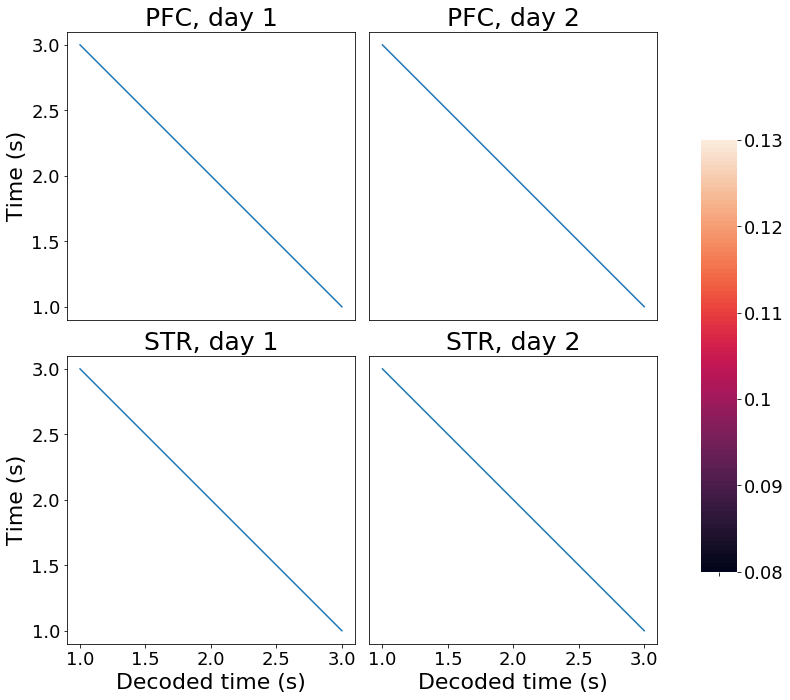

In [52]:
mlp.rcParams['font.size'] = 18
label_size, title_size = 22, 25

fig = plt.figure(figsize=(10,10))

vmin, vmax = 0.08,.13

ax1 = fig.add_axes([0,.45, .4, .4])
#res.proba_matrix(grouping=('tested_on','pfc_day1'), vmin=vmin, vmax=vmax, cbar=False, ax=ax);
ax1.plot([1,2,3],[3,2,1])
plt.title('PFC, day 1',fontsize=title_size);plt.xticks([]); plt.xlabel(''); plt.ylabel('Time (s)', fontsize=label_size)


ax2 = fig.add_axes([.42,.45, .4, .4])
#res.proba_matrix(grouping=('tested_on','pfc_day2'), vmin=vmin, vmax=vmax, cbar=False);
ax2.plot([1,2,3],[3,2,1])
plt.title('PFC, day 2',fontsize=title_size);plt.yticks([]);plt.ylabel('');plt.xticks([]); plt.xlabel('')


ax3 = fig.add_axes([0, 0, .4, .4])
#res.proba_matrix(grouping=('tested_on','str_day1'), vmin=vmin, vmax=vmax, cbar=False);
ax3.plot([1,2,3],[3,2,1])
plt.title('STR, day 1',fontsize=title_size); plt.ylabel('Time (s)', fontsize=label_size)
plt.xlabel('Decoded time (s)', fontsize=label_size)


ax4 = fig.add_axes([.42, 0, .4, .4])
#res.proba_matrix(grouping=('tested_on','str_day2'), vmin=vmin, vmax=vmax, cbar=False);
ax4.plot([1,2,3],[3,2,1]);plt.yticks([]);
ax4.set_ylabel('')
plt.title('STR, day 2',fontsize=title_size)
plt.xlabel('Decoded time (s)', fontsize=label_size)

ax=fig.add_axes((.88, .1, .05, .6), facecolor='w')
sns.heatmap(np.linspace(vmin,vmax,100).reshape(-1,1)[::-1],cbar=False, ax=ax)
ax.yaxis.tick_right()
ax.tick_params(rotation=0)
ax.set_yticks(np.linspace(0,100,101)[::-20]); ax.set_xticklabels(['']);
ax.set_yticklabels(np.linspace(vmin,vmax,101)[::20].round(3));

#plt.tight_layout()
#ax2.set_t

plt.savefig('/home/tevo/Desktop/teste.png', dpi=300, bbox_inches='tight')

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


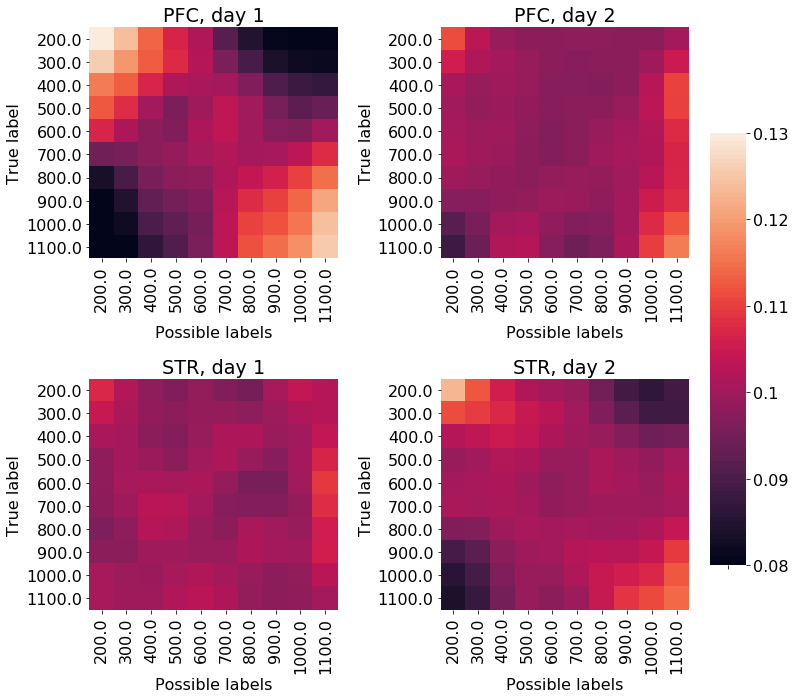

In [109]:
mlp.rcParams['font.size'] = 16

plt.figure(figsize=(10,10))

vmin, vmax = 0.08,.13

plt.subplot(2,2,1)
res.proba_matrix(grouping=('tested_on','pfc_day1'), vmin=vmin, vmax=vmax, cbar=False);
plt.title('PFC, day 1')
plt.subplot(2,2,2)
res.proba_matrix(grouping=('tested_on','pfc_day2'), vmin=vmin, vmax=vmax, cbar=False);
plt.title('PFC, day 2')
plt.subplot(2,2,3)
res.proba_matrix(grouping=('tested_on','str_day1'), vmin=vmin, vmax=vmax, cbar=False);
plt.title('STR, day 1')
plt.subplot(2,2,4)
res.proba_matrix(grouping=('tested_on','str_day2'), vmin=vmin, vmax=vmax, cbar=False);
plt.title('STR, day 2')

ax=plt.axes((1, .2, .05, .6), facecolor='w')
sns.heatmap(np.linspace(vmin,vmax,100).reshape(-1,1)[::-1],cbar=False, ax=ax)
ax.yaxis.tick_right()
ax.tick_params(rotation=0)
ax.set_yticks(np.linspace(0,100,101)[::-20]); ax.set_xticklabels(['']);
ax.set_yticklabels(np.linspace(vmin,vmax,101)[::20].round(3));

plt.tight_layout()

#plt.savefig('reports/figures/evolution_proba.png', dpi=300)

In [14]:
res.score['area'] = res.score.trained_on.apply(lambda x: x[:3])
res.score['day'] = res.score.trained_on.apply(lambda x: x[-1])

In [ ]:
mlp.rcParams['font.size'] = 16

plt.figure(figsize=(10,10))

vmin, vmax = 0.08,.13

plt.subplot(2,2,1)
res.confusion_matrix(grouping=('tested_on','pfc_day1'), vmin=vmin, vmax=vmax, cbar=False);
plt.xticks([]); plt.xlabel('')
plt.title('PFC, day 1')
plt.subplot(2,2,2)
res.confusion_matrix(grouping=('tested_on','pfc_day2'), vmin=vmin, vmax=vmax, cbar=False); 
plt.yticks([]);plt.ylabel('');plt.xticks([]); plt.xlabel('')
plt.title('PFC, day 2')
plt.subplot(2,2,3)
res.confusion_matrix(grouping=('tested_on','str_day1'), vmin=vmin, vmax=vmax, cbar=False);
plt.title('STR, day 1')
plt.subplot(2,2,4)
res.confusion_matrix(grouping=('tested_on','str_day2'), vmin=vmin, vmax=vmax, cbar=False); 
plt.yticks([]);plt.ylabel('')
plt.title('STR, day 2')

ax=plt.axes((1, .2, .05, .6), facecolor='w')
sns.heatmap(np.linspace(vmin,vmax,100).reshape(-1,1)[::-1],cbar=False, ax=ax)
ax.yaxis.tick_right()
ax.tick_params(rotation=0)
ax.set_yticks(np.linspace(0,100,101)[::-20]); ax.set_xticklabels(['']);
ax.set_yticklabels(np.linspace(vmin,vmax,101)[::20].round(3));

plt.tight_layout()

#plt.savefig('reports/figures/evolution_proba.png', dpi=300)

In [15]:
import seaborn as sns
import matplotlib as mlp

In [69]:
b = ax.legend(

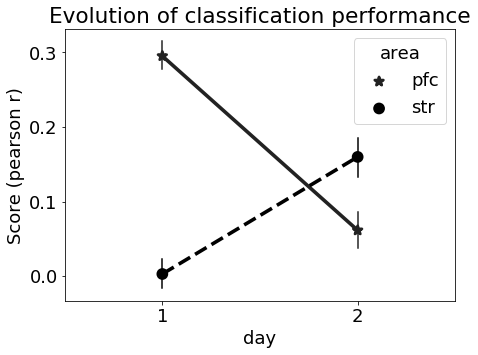

In [84]:
mlp.rcParams['font.size'] = 18
mlp.rcParams['lines.linewidth'] = 2
plt.figure(figsize=(7,5))
ax=sns.pointplot(x='day', y='pearson_mean', hue='area', data=res.score, color='k',
              markers=['*','o'], linestyles=['-','--'], errwidth=1.5)
#plt.text(0, .08,'Striatum')

#plt.setp(ax.collections, sizes=[200])
plt.ylabel('Score (pearson r)')
plt.title('Evolution of classification performance');
plt.savefig('reports/figures/evolution.png', dpi=200)

---

---

In [11]:
%load_ext autoreload
%autoreload 2

In [163]:
fdf.shape

(3080, 133)

In [165]:
from sklearn.linear_model import LogisticRegression

In [178]:
fdf.loc[:50]

unit               0 u0       0 u2       0 u4        0 u6       0 u7  \
trial time                                                             
0.0   200.0    0.572880   0.000000   3.506017   61.119710   0.000000   
      300.0    2.578338   0.000000   7.428614   56.190491   0.000000   
      400.0    5.596282   0.000000  10.631659   50.546460   0.000000   
      500.0    6.293144   0.000000  12.444572   48.500972   0.000000   
      600.0    3.766102   0.000000  13.791667   49.997854   0.000000   
      700.0    1.079626   0.000000  11.568875   52.829690   0.000000   
      800.0    0.156986   0.014305   9.664921   60.164215   0.000000   
      900.0    0.661611   0.500474  12.012210   77.366684   0.000000   
      1000.0   3.834381   3.195497  14.899219   92.776616   0.006288   
      1100.0   9.474081   8.558522  15.817634   96.505835   0.276023   
1.0   200.0    0.976091  12.827472   5.187527   72.793135   9.151727   
      300.0    4.660498  15.972859  10.190233   74.081747   7.003289   
      400.0   10.432533  21.858607  11.905548   68.872949   5.372236   
      500.0   11.376473  25.509877  10.108710   59.120026   4.665797   
      600.0    7.677578  28.014525  10.935092   63.799425   2.988194   
      700.0    4.258966  45.898762  14.484794   98.130422   1.639389   
      800.0    3.242354  78.114898  13.869063  138.788918   2.853062   
      900.0    4.118066  91.193256   8.873919  145.735708   3.788470   
      1000.0   4.184600  72.758524   5.740756  122.845423   2.081037   
      1100.0   6.218029  52.872173   9.048188  111.868223   0.456031   
2.0   200.0   11.741056   7.428374   8.792414   64.814505   0.000000   
      300.0    6.359129  13.958799   7.228164   67.953437   0.000000   
      400.0    1.735946  17.901128   5.952551   60.039391   0.000000   
      500.0    0.896835  19.936570   4.824441   53.037139   0.000000   
      600.0    4.475854  28.379079   2.581206   58.785019   0.000000   
      700.0   12.176818  36.275733   1.083792   71.883129   0.000000   
      800.0   15.581677  27.158131   2.154414   68.825917   0.000000   
      900.0   11.127514  14.221072   3.793667   57.136427   0.000000   
      1000.0   6.629097  12.233087   2.742200   53.672507   0.000000   
      1100.0   6.407431  11.835477   0.792325   57.787185   0.038220   
...                 ...        ...        ...         ...        ...   
48.0  200.0    1.928001   0.000000   0.000000    0.000000   0.008233   
      300.0    3.612296   0.000000   0.000000    0.000000   0.294763   
      400.0    3.185631   0.017886   0.011099    0.000000   1.650191   
      500.0    1.126806   0.380146   0.327614    0.000000   3.976426   
      600.0    0.153953   1.885111   2.036218    0.000000   5.121167   
      700.0    0.000000   3.726660   5.796784    0.000000   5.584580   
      800.0    0.000000   2.951718   9.223975    0.000000   6.171903   
      900.0    0.000000   0.935044   9.434236    0.000000   7.336643   
      1000.0   0.000000   0.110121   7.415122    0.000000   9.475786   
      1100.0   0.000000   0.000000   5.781698    0.000000  10.413739   
49.0  200.0    0.000000   0.000000   6.466835    0.000000   2.009477   
      300.0    0.000000   0.000000   2.931113    0.000000   3.649169   
      400.0    0.048829   0.000000   0.602310    0.000000   3.129335   
      500.0    0.862425   0.000000   0.489973    0.000000   1.076803   
      600.0    4.031758   0.000000   2.081037    0.000000   0.141903   
      700.0    7.535720   0.000000   3.901819    0.000000   0.000000   
      800.0    5.888013   0.000000   3.713779    0.000000   0.000000   
      900.0    3.133635   0.000000   3.777925    0.000000   0.019829   
      1000.0   3.655938   0.000000   3.802294    0.000000   0.396094   
      1100.0   3.464528   0.000000   1.863657    0.000000   1.928231   
50.0  200.0    1.096737   1.763046   2.839137    0.012657   0.009625   
      300.0    4.544276   7.841176   8.726705    0.553174   0.320473   
      400.0   10.597177  17.665813  13.4

In [183]:
res_beg = shuffle_val_predict(LogisticRegression(), [fdf.loc[:100]], n_splits=10)
res_late = shuffle_val_predict(LogisticRegression(), [fdf.loc[100:200]], n_splits=10)

In [187]:
res = shuffle_val_predict(LogisticRegression(), [fdf], n_splits=50)

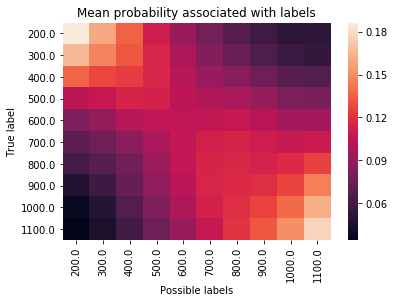

In [188]:
res.proba_matrix();

In [152]:
to_select = [select(df, _min_duration=1.5, is_selected=True) for df in dfs]
ntrials = np.min([df.reset_index('trial').trial.nunique() for df in to_select])
to_merge=[]
for df in to_select:
    df = df.reset_index()
    df = df[df.trial <= df.trial.unique()[ntrials-1]]
    nunits = df.unit.nunique()
    df['trial']=np.vstack([t*np.ones((nunits,1)) for t in range(ntrials)])

    to_merge.append(to_feature_array(df.set_index(['trial','unit'])))

In [153]:

for i, df in enumerate(to_merge):
    df.columns = pd.Index(['%d u%s'%(i, c) for c in df.columns], name='unit')

In [99]:
import numpy as np

In [95]:

    to_merge=[]
    for df in to_select:
        df = df.reset_index()
        df = df.iloc[:smaller.shape[0],:]
        df['trial'] = smaller.trial
        to_merge.append(to_feature_array(df.set_index(['trial','unit'])))
    for i, df in enumerate(to_merge):
        df.columns = pd.Index(['%d u%s'%(i, c) for c in df.columns], name='unit')
    return to_merge

unit               0 u0       0 u2       0 u4        0 u6       0 u7  \
trial time                                                             
1     200.0    0.572880   0.000000   3.506017   61.119710   0.000000   
      300.0    2.578338   0.000000   7.428614   56.190491   0.000000   
      400.0    5.596282   0.000000  10.631659   50.546460   0.000000   
      500.0    6.293144   0.000000  12.444572   48.500972   0.000000   
      600.0    3.766102   0.000000  13.791667   49.997854   0.000000   
      700.0    1.079626   0.000000  11.568875   52.829690   0.000000   
      800.0    0.156986   0.014305   9.664921   60.164215   0.000000   
      900.0    0.661611   0.500474  12.012210   77.366684   0.000000   
      1000.0   3.834381   3.195497  14.899219   92.776616   0.006288   
      1100.0   9.474081   8.558522  15.817634   96.505835   0.276023   
11    200.0    0.976091  12.827472   5.187527   72.793135   9.151727   
      300.0    4.660498  15.972859  10.190233   74.081747   7.003289   
      400.0   10.432533  21.858607  11.905548   68.872949   5.372236   
      500.0   11.376473  25.509877  10.108710   59.120026   4.665797   
      600.0    7.677578  28.014525  10.935092   63.799425   2.988194   
      700.0    4.258966  45.898762  14.484794   98.130422   1.639389   
      800.0    3.242354  78.114898  13.869063  138.788918   2.853062   
      900.0    4.118066  91.193256   8.873919  145.735708   3.788470   
      1000.0   4.184600  72.758524   5.740756  122.845423   2.081037   
      1100.0   6.218029  52.872173   9.048188  111.868223   0.456031   
13    200.0         NaN        NaN        NaN         NaN        NaN   
      300.0         NaN        NaN        NaN         NaN        NaN   
      400.0         NaN        NaN        NaN         NaN        NaN   
      500.0         NaN        NaN        NaN         NaN        NaN   
      600.0         NaN        NaN        NaN         NaN        NaN   
      700.0         NaN        NaN        NaN         NaN        NaN   
      800.0         NaN        NaN        NaN         NaN        NaN   
      900.0         NaN        NaN        NaN         NaN        NaN   
      1000.0        NaN        NaN        NaN         NaN        NaN   
      1100.0        NaN        NaN        NaN         NaN        NaN   
...                 ...        ...        ...         ...        ...   
925   200.0    1.242745  22.310892   8.692104    9.067609  10.745216   
      300.0    5.923559  36.709268  17.528174   16.680125  12.286666   
      400.0   13.356678  40.773138  30.204431   21.261534   9.246176   
      500.0   14.871464  31.924261  48.013113   25.125461   5.261437   
      600.0   10.960475  18.970564  51.572574   23.496440   2.062149   
      700.0    8.806258  11.284928  27.328287   11.995252   0.404261   
      800.0    7.640756   6.127447   6.312157    4.450207   0.072195   
      900.0    5.058129   1.800248   0.543569    4.399520   0.618662   
      1000.0   1.869299   0.212924   0.716551    5.251500   2.435823   
      1100.0   0.307816   0.000000   3.048269    5.252281   3.830244   
929   200.0    5.289046   0.000000   0.017886    0.000000        NaN   
      300.0    8.287189   0.000000   0.396193    0.000000        NaN   
      400.0    8.480277   0.041574   2.268660    0.017886        NaN   
      500.0    6.479181   1.170492   5.956994    0.380146        NaN   
      600.0    6.365397   7.435088   8.641903    2.090324        NaN   
      700.0    9.456434  21.934216   8.414661    5.048094        NaN   
      800.0   11.174782  35.400184   6.725037    6.328689        NaN   
      900.0   10.305357  35.982456   5.984091    4.684810        NaN   
      1000.0  10.900565  34.447788   8.492223    3.769000        NaN   
      1100.0  12.655671  47.222285  14.512639    7.141485        NaN   
930   200.0         NaN        NaN        NaN         NaN   0.000000   
      300.0         NaN        NaN        NaN         NaN   0.271634   
      400.0         NaN        NaN      

In [84]:
import pandas as pd

In [80]:
dm = to_feature_array(select(d, _min_duration=1.5, is_selected=True))

In [ ]:
smaller

In [74]:
d = io.load('DRRD 7', 'wide_smoothed')